# Regression Challenge

Predicting the selling price of a residential property depends on a number of factors, including the property age, availability of local amenities, and location.

In this challenge, you will use a dataset of real estate sales transactions to predict the price-per-unit of a property based on its features. The price-per-unit in this data is based on a unit measurement of 3.3 square meters.

> **Citation**: The data used in this exercise originates from the following study:
>
> *Yeh, I. C., & Hsu, T. K. (2018). Building real estate valuation models with comparative approach through case-based reasoning. Applied Soft Computing, 65, 260-271.*
>
> It was obtained from the UCI dataset repository (Dua, D. and Graff, C. (2019). [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science).

## Review the data

Run the following cell to load the data and view the first few rows.

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load the training dataset
data = pd.read_csv('data/real_estate.csv')
data.head()

,transaction_date,house_age,transit_distance,local_convenience_stores,latitude,longitude,price_per_unit
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


The data consists of the following variables:

- **transaction_date** - the transaction date (for example, 2013.250=2013 March, 2013.500=2013 June, etc.)
- **house_age** - the house age (in years)
- **transit_distance** - the distance to the nearest light rail station (in meters)
- **local_convenience_stores** - the number of convenience stores within walking distance
- **latitude** - the geographic coordinate, latitude
- **longitude** - the geographic coordinate, longitude
- **price_per_unit** house price of unit area (3.3 square meters)

## Train a Regression Model

Your challenge is to explore and prepare the data, identify predictive features that will help predict the **price_per_unit** label, and train a regression model that achieves the lowest Root Mean Square Error (RMSE) you can achieve (which must be less than **7**) when evaluated against a test subset of data.

Add markdown and code cells as required to create your solution.

> **Note**: There is no single "correct" solution. A sample solution is provided in [02 - Real Estate Regression Solution.ipynb](02%20-%20Real%20Estate%20Regression%20Solution.ipynb).

### EDA

In [2]:
data.describe()

,transaction_date,house_age,transit_distance,local_convenience_stores,latitude,longitude,price_per_unit
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


/tmp/ipykernel_35479/4161167399.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),


<AxesSubplot:>

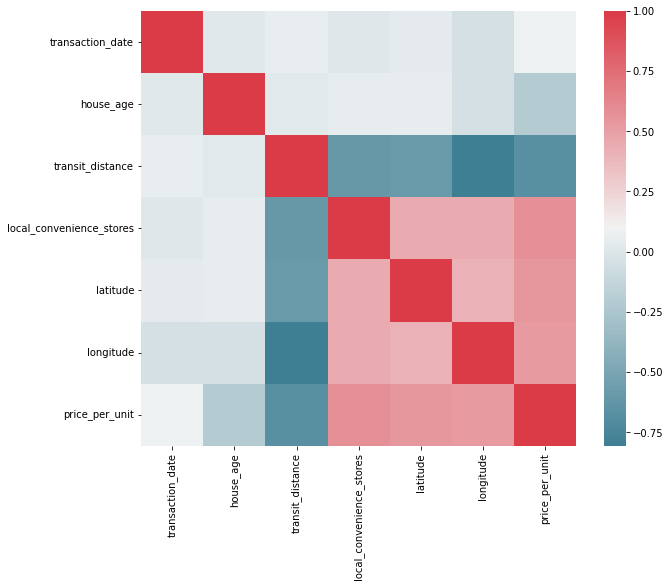

In [7]:
corr = data.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

/tmp/ipykernel_31213/2649913440.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


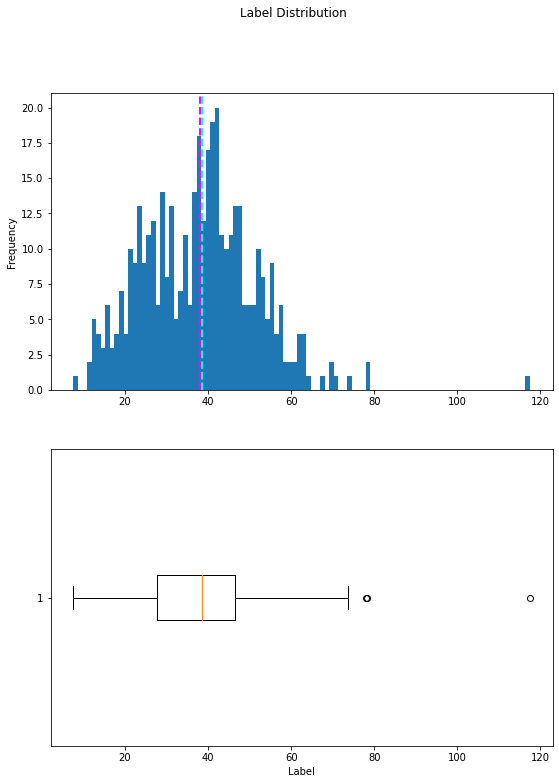

In [4]:
# Get the label column
label = data[data.columns[-1]]

# Create a figure for 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize = (9,12))

# Plot the histogram   
ax[0].hist(label, bins=100)
ax[0].set_ylabel('Frequency')

# Add lines for the mean, median, and mode
ax[0].axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax[0].axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2)

# Plot the boxplot   
ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('Label')

# Add a title to the Figure
fig.suptitle('Label Distribution')

# Show the figure
fig.show()

We need to remove outliers: 

In [19]:
data_fix = data.loc[data["price_per_unit"]<70,:]

In [20]:
X, y = data_fix[['transaction_date',
                 'house_age',
                 'transit_distance',
                 'local_convenience_stores',
                 'latitude',
                 'longitude']].values, data_fix['price_per_unit'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [21]:
print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 285 rows
Test Set: 123 rows


### Preprocessing


In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [23]:
# Define preprocessing for numeric columns (scale them)
numeric_features = [#0,
                    1,2,3,4,5]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode them)
#categorical_features = [0,1,2,3,4,5]
#categorical_transformer = Pipeline(steps=[
#    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
#        ('cat', categorical_transformer, categorical_features)
        ])

MSE: 37.3986793583475
RMSE: 6.115445965614241
R2: 0.6808753797667939


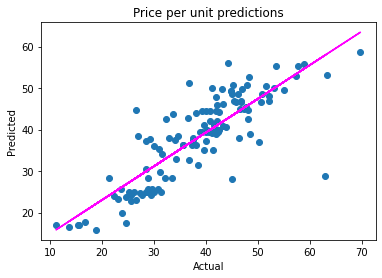

In [24]:
# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor())])

# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, (y_train))

# Get predictions
predictions = model.predict(X_test)

# Display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Price per unit predictions')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

MSE: 38.1081251292115
RMSE: 6.173177879278346
R2: 0.6748216469589134


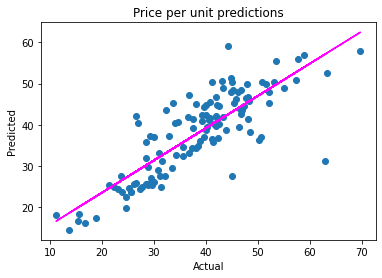

In [25]:
# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor())])

# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, (y_train))

# Get predictions
predictions = model.predict(X_test)

# Display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Price per unit predictions')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

## Use the Trained Model

Save your trained model, and then use it to predict the price-per-unit for the following real estate transactions:

| transaction_date | house_age | transit_distance | local_convenience_stores | latitude | longitude |
| ---------------- | --------- | ---------------- | ------------------------ | -------- | --------- |
|2013.167|16.2|289.3248|5|24.98203|121.54348|
|2013.000|13.6|4082.015|0|24.94155|121.50381|

In [26]:
import joblib

# Save the model as a pickle file
filename = './real_estate_model.pkl'
joblib.dump(model, filename)

# Load the model from the file
loaded_model = joblib.load(filename)

# An array of features for each transaction (don't include the transaction date)
X_new = np.array([[2013.167,16.2,289.3248,5,24.98203,121.54348],
                  [2013.000,13.6,4082.015,0,24.94155,121.5038]])

# Use the model to predict unit price
results = loaded_model.predict(X_new)
print('Predictions:')
for prediction in results:
    print(round(prediction,2))

Predictions:
49.04
16.61
